# Análise da distribuição do seguro rural nas Regiões do Brasil

## Importando as bibliotecas

In [1]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install jenkspy
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3

     |████████████████████████████████| 962 kB 5.3 MB/s 
     |████████████████████████████████| 16.7 MB 234 kB/s 
     |████████████████████████████████| 6.3 MB 34.4 MB/s 
     |████████████████████████████████| 44 kB 1.5 MB/s 
     |████████████████████████████████| 1.8 MB 4.6 MB/s 
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.0
    Uninstalling Shapely-1.8.0:
      Successfully uninstalled Shapely-1.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 55 kB 1.1 MB/s 
  Created wheel for jenkspy: filename=jenkspy-0.2.0-cp37-cp37m-linux_x86_64.whl size=71198 sha256=3aa0993f42ffce4af733dfd16fec1a8b22f4b0f5365997e69dc7c6d408d5542a
  Stored in directory: /root/.cache/pip/wheels/d8/d1/42/9bd051

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
import jenkspy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches, colors
from matplotlib.lines import Line2D
from matplotlib.collections import EventCollection
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection  
from matplotlib import rcParams
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline
# sns.set(style='whitegrid', palette='pastel') 
#sns.set(style='white', palette='deep') 
import warnings
warnings.filterwarnings("ignore")
mpl.rcdefaults()

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler 

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

import shapefile
from google.colab import drive, files

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
img=mpimg.imread('/content/drive/My Drive/Mestrado/Imagens/rosa_dos_ventos_3.png')
img2=mpimg.imread('/content/drive/My Drive/Mestrado/Imagens/rosa_dos_ventos_p.png')

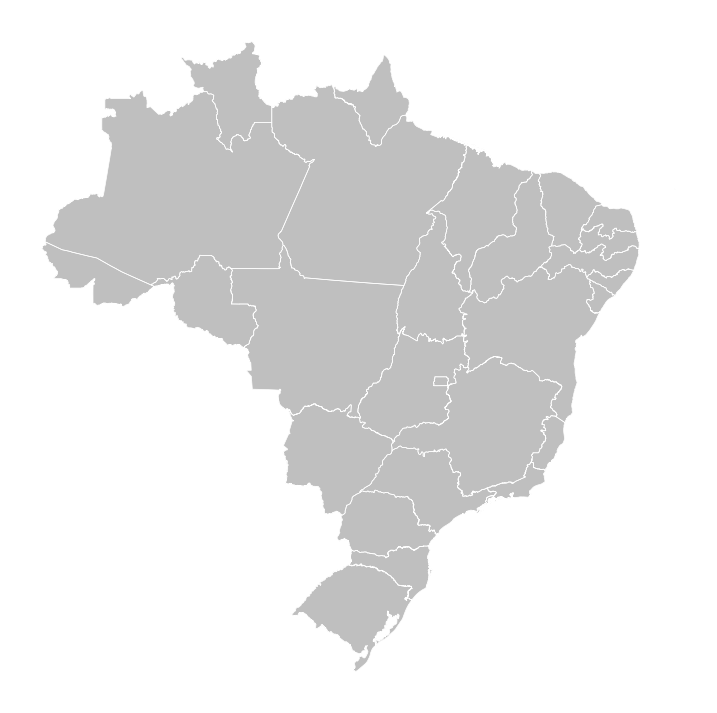

In [5]:
#Regioes geograficas
sf = shapefile.Reader('/content/drive/My Drive/Mestrado/Dados/estados/estados_2010.shp')
shapes = sf.shapes()
Nshp = len(shapes)

ptchs   = []
for nshp in range(Nshp):
    pts     = np.array(shapes[nshp].points)
    prt     = shapes[nshp].parts
    par     = list(prt) + [pts.shape[0]]

    for pij in range(len(prt)):
       ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))

#UF
sf_uf = shapefile.Reader('/content/drive/My Drive/Mestrado/Dados/estados/estados_2010.shp')
shapes = sf.shapes()
shapes_uf = sf_uf.shapes()
Nshp_uf = len(shapes_uf)

ptchs_uf   = []
for nshp_uf in range(Nshp_uf):
    pts_uf     = np.array(shapes_uf[nshp_uf].points)
    prt_uf     = shapes_uf[nshp_uf].parts
    par_uf     = list(prt_uf) + [pts_uf.shape[0]]

    for pij_uf in range(len(prt_uf)):
       ptchs_uf.append(Polygon(pts_uf[par_uf[pij_uf]:par_uf[pij_uf+1]]))


fig     = plt.figure(figsize = (9,9))
ax      = fig.add_subplot(111)

ax.add_collection(PatchCollection(ptchs,facecolor='0.75', edgecolor='w', linewidths=0))
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))
ax.axis('auto'); ax.axis('off')
plt.show()
# Fonte: http://www.phme.it/wilt/2017/05/06/dynamic-mapping-with-shapefiles-and-python/

# Dados

### Dados de seguro rural

In [6]:
link = 'https://raw.githubusercontent.com/walefmachado/spreg_rural_insurance/main/dados/'

In [7]:
dados_br = pd.read_csv(link+'/dados_06_19.csv')

### Dados para espacial 

In [8]:
cod = pd.read_csv(link+'/codigos-mun.csv')

br = geopandas.read_file(link+'/br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

dados_br = cod_dados.merge(dados_br, on='mun', how='left')
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop(['rm', 'nome_mun_y', 'nome_meso_y', 'sinistralidade_media'], axis = 1)
dados_br.rename(columns = {'nome_mun_x':'nome_mun', 'nome_meso_x':'nome_meso' }, inplace = True)

In [9]:
dados_br = dados_br.rename({'apolices_contratadas':'ap_contrat',
                            'total_segurado_mil':'t_segurado',
                            'soma_premio_total_mil':'soma_premio',
                            'total_subvencao_mil':'t_subvencao',
                            'valor_indenizacoes_pagas_mil':'inde_pagas',
                            'taxa_media':'tx_media',
                            'apolices_indenizadas':'ap_indeniz'}, axis=1)
#variaveis = ['apolices_contratadas', 'total_segurado_mil', 'soma_premio_total_mil', 'total_subvencao_mil', 'valor_indenizacoes_pagas_mil', 'taxa_media', 'apolices_indenizadas']
variaveis = ['ap_contrat', 't_segurado', 'soma_premio', 't_subvencao', 'inde_pagas', 'tx_media', 'ap_indeniz']
geometry = ['mun', 'geometry']    

In [10]:
dados_br.drop(index=dados_br[dados_br['mun'] == 2605459].index, inplace=True) # retira F. Noronha e Ilhabela
dados_br.drop(index=dados_br[dados_br['mun'] == 3520400].index, inplace=True) 

In [11]:
dados_19 = dados_br[dados_br['ano']==2019][variaveis]
dados_19_geo = dados_br[dados_br['ano']==2019][geometry]
dados_geo = dados_br[dados_br['ano']==2019][geometry]

In [12]:
anos = dados_br.ano.unique()

# Regiões

## Norte

In [13]:
dados_norte = dados_br.query('nome_regiao == "Norte"')

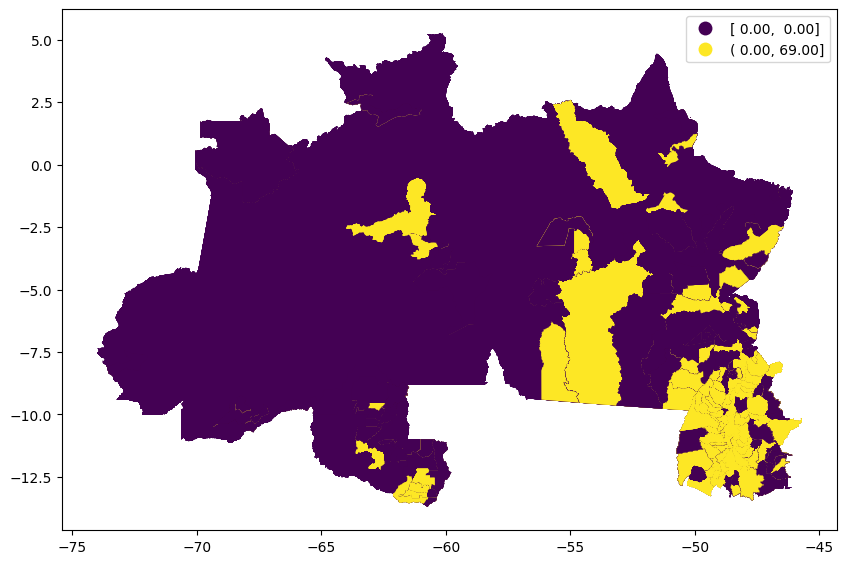

In [14]:
dados_norte.plot(column='ap_contrat', figsize=(10, 10), scheme='quantiles', legend=True); # , cmap='OrRd' scheme='quantiles',

In [15]:
w = Queen.from_dataframe(dados_norte[dados_norte['ano'] == 2019])

In [16]:
mi_results = []
table_I = pd.DataFrame(dados_norte.ano.unique(), columns=['anos'])
for variavel in variaveis:
    mi_results = [Moran(dados_norte[dados_norte['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.I, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I = pd.concat([table_I.reset_index(drop=True), table_p], axis=1)
table_I

,anos,ap_contrat,t_segurado,soma_premio,t_subvencao,inde_pagas,tx_media,ap_indeniz
0,2006,-0.003,-0.003,-0.003,-0.003,NaN,-0.003,NaN
1,2007,-0.005,-0.002,-0.005,-0.005,NaN,-0.005,NaN
2,2008,0.218,0.143,0.127,0.128,-0.006,0.299,-0.006
3,2009,0.315,0.004,0.247,0.247,0.049,0.421,0.070
4,2010,0.261,0.156,0.142,0.140,-0.006,0.226,-0.006
5,2011,0.169,0.105,0.104,0.103,NaN,0.245,NaN
6,2012,0.279,0.104,0.115,0.160,-0.004,0.336,-0.005
7,2013,0.417,0.302,0.282,0.304,0.001,0.462,0.040
8,2014,0.409,0.386,0.394,0.408,0.093,0.459,0.051
9,2015,0.115,0.077,0.076,0.089,0.011,0.094,0.019


In [17]:
mi_results = []
table_I_p = pd.DataFrame(dados_norte.ano.unique(), columns=['anos'])
for variavel in variaveis:
    mi_results = [Moran(dados_norte[dados_norte['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.p_sim, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I_p = pd.concat([table_I_p.reset_index(drop=True), table_p], axis=1)
table_I_p

,anos,ap_contrat,t_segurado,soma_premio,t_subvencao,inde_pagas,tx_media,ap_indeniz
0,2006,0.252,0.249,0.260,0.262,0.001,0.287,0.001
1,2007,0.260,0.349,0.369,0.347,0.001,0.107,0.001
2,2008,0.002,0.002,0.003,0.008,0.378,0.001,0.476
3,2009,0.001,0.104,0.001,0.001,0.008,0.001,0.008
4,2010,0.002,0.002,0.003,0.005,0.046,0.001,0.042
5,2011,0.001,0.012,0.013,0.015,0.001,0.001,0.001
6,2012,0.001,0.011,0.005,0.002,0.211,0.001,0.269
7,2013,0.001,0.001,0.001,0.001,0.101,0.001,0.047
8,2014,0.001,0.001,0.001,0.001,0.020,0.001,0.039
9,2015,0.007,0.021,0.023,0.017,0.098,0.013,0.104


In [18]:
w = Queen.from_dataframe(dados_norte[dados_norte['ano'] == 2019])
np.random.seed(123456)

y = dados_norte[dados_norte['ano'] == 2019]
mi_results = [Moran(y[variable], w) for variable in variaveis]
table = pd.DataFrame([(variable, res.I, res.p_sim) \
                      for variable,res in zip(variaveis, mi_results)], columns=['Variável', "I", 'valor-p']).set_index('Variável')
table

,I,valor-p
Variável,,
ap_contrat,0.512343,0.001
t_segurado,0.487016,0.001
soma_premio,0.505479,0.001
t_subvencao,0.510696,0.001
inde_pagas,0.148905,0.003
tx_media,0.584657,0.001
ap_indeniz,0.200599,0.002


In [19]:
dados_menos_norte = dados_br.query('nome_regiao != "Norte"')

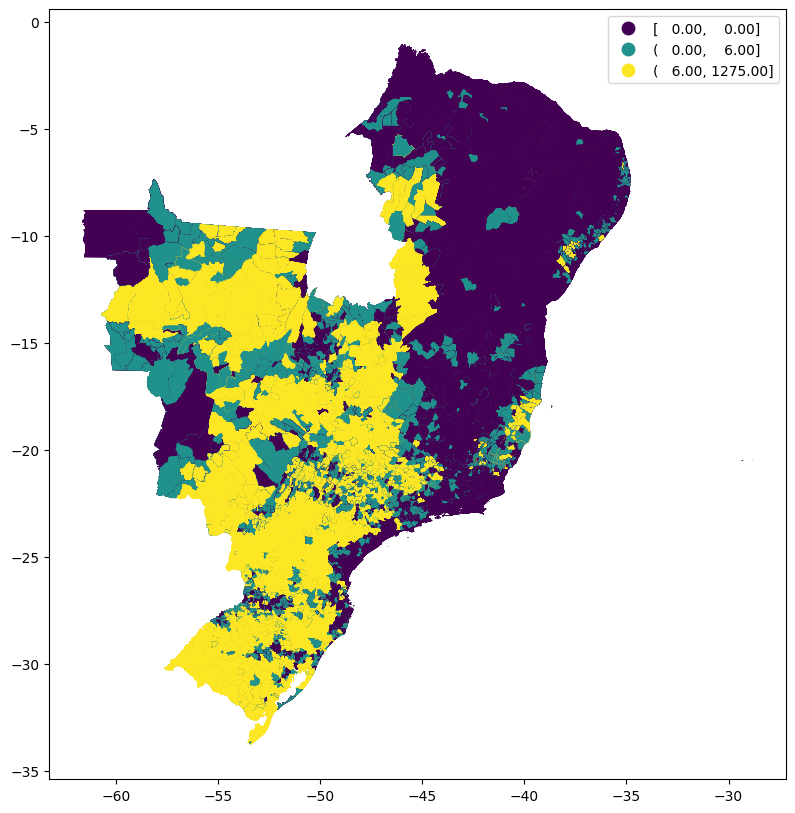

In [20]:
dados_menos_norte.plot(column='ap_contrat', figsize=(10, 10), scheme='quantiles', legend=True); # , cmap='OrRd' scheme='quantiles',

In [21]:
w = Queen.from_dataframe(dados_menos_norte[dados_menos_norte['ano'] == 2019])

In [22]:
mi_results = []
table_I = pd.DataFrame(dados_menos_norte.ano.unique(), columns=['anos'])
for variavel in variaveis:
    mi_results = [Moran(dados_menos_norte[dados_menos_norte['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.I, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I = pd.concat([table_I.reset_index(drop=True), table_p], axis=1)
table_I

,anos,ap_contrat,t_segurado,soma_premio,t_subvencao,inde_pagas,tx_media,ap_indeniz
0,2006,0.560,0.002,0.160,0.237,0.030,0.317,0.167
1,2007,0.494,0.144,0.182,0.218,0.097,0.009,0.227
2,2008,0.467,0.300,0.295,0.324,0.401,0.606,0.447
3,2009,0.500,0.402,0.341,0.338,0.228,0.708,0.325
4,2010,0.475,0.350,0.297,0.296,0.177,0.528,0.238
5,2011,0.507,0.385,0.316,0.311,0.337,0.708,0.410
6,2012,0.539,0.439,0.375,0.376,0.228,0.726,0.419
7,2013,0.559,0.414,0.424,0.432,0.329,0.728,0.495
8,2014,0.586,0.434,0.410,0.416,0.304,0.782,0.451
9,2015,0.599,0.456,0.406,0.412,0.465,0.782,0.543


In [23]:
#outliers = Moran_Local(m1.u, w, permutations=9999)
#lisa_cluster(outliers, dados_sul, p=0.05, figsize = (10,10));

In [24]:
#f, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 30))
#axs = axs.flatten()
#for i, col in enumerate(variaveis):
#    ax = axs[i]
#    outliers = Moran_Local(dados_norte[col], w, permutations=9999)
#    lisa_cluster(outliers, dados_norte, ax=ax, p=0.05, figsize = (10,10));
#    #dados_sul.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0, cmap='RdPu')
#    ax.set_axis_off()
#    ax.set_title(col)
#plt.show();

## Nordeste

In [25]:
dados_nordeste = dados_br.query('nome_regiao == "Nordeste"')

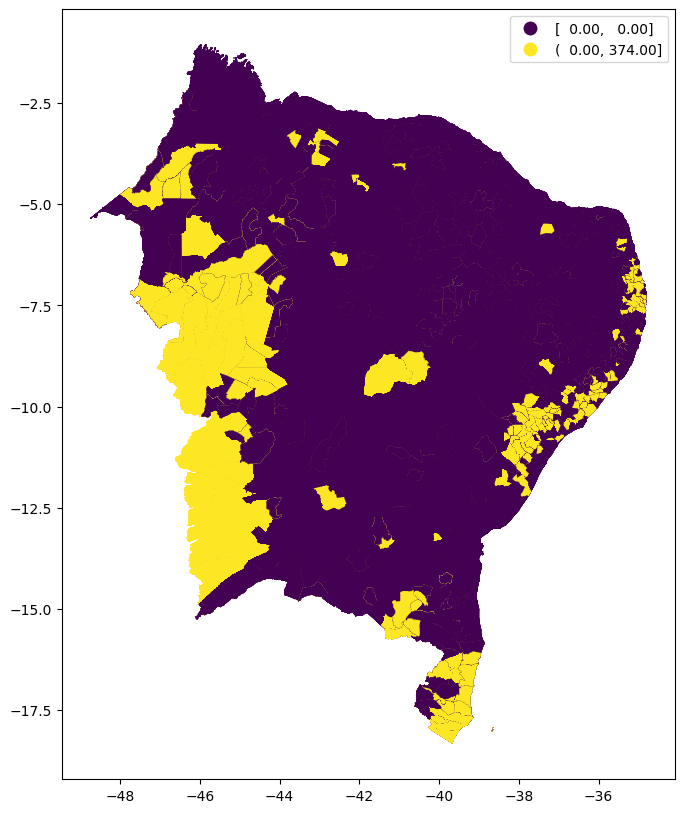

In [26]:
dados_nordeste.plot(column='ap_contrat', figsize=(10, 10), scheme='quantiles', legend=True); # , cmap='OrRd' scheme='quantiles',

In [27]:
w = Queen.from_dataframe(dados_nordeste[dados_nordeste['ano'] == 2019])

In [28]:
mi_results = []
table_I = pd.DataFrame(dados_nordeste.ano.unique(), columns=['anos'])
for variavel in variaveis:
    mi_results = [Moran(dados_nordeste[dados_nordeste['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.I, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I = pd.concat([table_I.reset_index(drop=True), table_p], axis=1)
table_I

,anos,ap_contrat,t_segurado,soma_premio,t_subvencao,inde_pagas,tx_media,ap_indeniz
0,2006,0.111,0.153,0.139,0.145,-0.001,0.075,-0.001
1,2007,0.124,0.095,0.174,0.177,NaN,0.022,NaN
2,2008,0.280,0.312,0.252,0.254,0.047,0.347,0.039
3,2009,0.303,0.311,0.274,0.274,0.093,0.476,0.102
4,2010,0.246,0.203,0.188,0.188,-0.002,0.483,-0.001
5,2011,0.107,0.108,0.091,0.091,0.286,0.478,0.294
6,2012,0.231,0.232,0.213,0.214,0.202,0.467,0.189
7,2013,0.250,0.253,0.276,0.267,0.240,0.536,0.239
8,2014,0.272,0.300,0.286,0.270,0.398,0.474,0.352
9,2015,0.176,0.272,0.255,0.263,0.201,0.341,0.190


In [29]:
mi_results = []
table_I_p = pd.DataFrame(dados_nordeste.ano.unique(), columns=['anos'])
for variavel in variaveis:
    mi_results = [Moran(dados_nordeste[dados_nordeste['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.p_sim, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I_p = pd.concat([table_I_p.reset_index(drop=True), table_p], axis=1)
table_I_p

,anos,ap_contrat,t_segurado,soma_premio,t_subvencao,inde_pagas,tx_media,ap_indeniz
0,2006,0.003,0.002,0.003,0.002,0.359,0.007,0.346
1,2007,0.003,0.003,0.001,0.002,0.001,0.005,0.001
2,2008,0.001,0.001,0.001,0.001,0.019,0.001,0.016
3,2009,0.001,0.001,0.001,0.001,0.003,0.001,0.006
4,2010,0.001,0.001,0.001,0.001,0.208,0.001,0.485
5,2011,0.003,0.001,0.003,0.002,0.001,0.001,0.001
6,2012,0.001,0.001,0.001,0.001,0.001,0.001,0.001
7,2013,0.002,0.001,0.001,0.001,0.001,0.001,0.001
8,2014,0.001,0.001,0.001,0.001,0.001,0.001,0.001
9,2015,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [30]:
w = Queen.from_dataframe(dados_nordeste[dados_nordeste['ano'] == 2019])
np.random.seed(123456)

y = dados_nordeste[dados_nordeste['ano'] == 2019]
mi_results = [Moran(y[variable], w) for variable in variaveis]
table = pd.DataFrame([(variable, res.I, res.p_sim) \
                      for variable,res in zip(variaveis, mi_results)], columns=['Variável', "I", 'valor-p']).set_index('Variável')
table

,I,valor-p
Variável,,
ap_contrat,0.277304,0.001
t_segurado,0.255065,0.001
soma_premio,0.254860,0.001
t_subvencao,0.254871,0.001
inde_pagas,0.345516,0.001
tx_media,0.549462,0.001
ap_indeniz,0.476476,0.001


In [31]:
#outliers = Moran_Local(m1.u, w, permutations=9999)
#lisa_cluster(outliers, dados_sul, p=0.05, figsize = (10,10));

In [32]:
#f, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 30))
#axs = axs.flatten()
#for i, col in enumerate(variaveis):
#    ax = axs[i]
#    outliers = Moran_Local(dados_norte[col], w, permutations=9999)
#    lisa_cluster(outliers, dados_norte, ax=ax, p=0.05, figsize = (10,10));
#    #dados_sul.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0, cmap='RdPu')
#    ax.set_axis_off()
#    ax.set_title(col)
#plt.show();

In [33]:
dados_br.nome_regiao.unique()

array(['Norte', 'Nordeste', 'Sudeste', 'Sul', 'Centro-Oeste'],
      dtype=object)

## Centro-Oeste

In [34]:
dados_centro_oeste = dados_br.query('nome_regiao == "Centro-Oeste"')

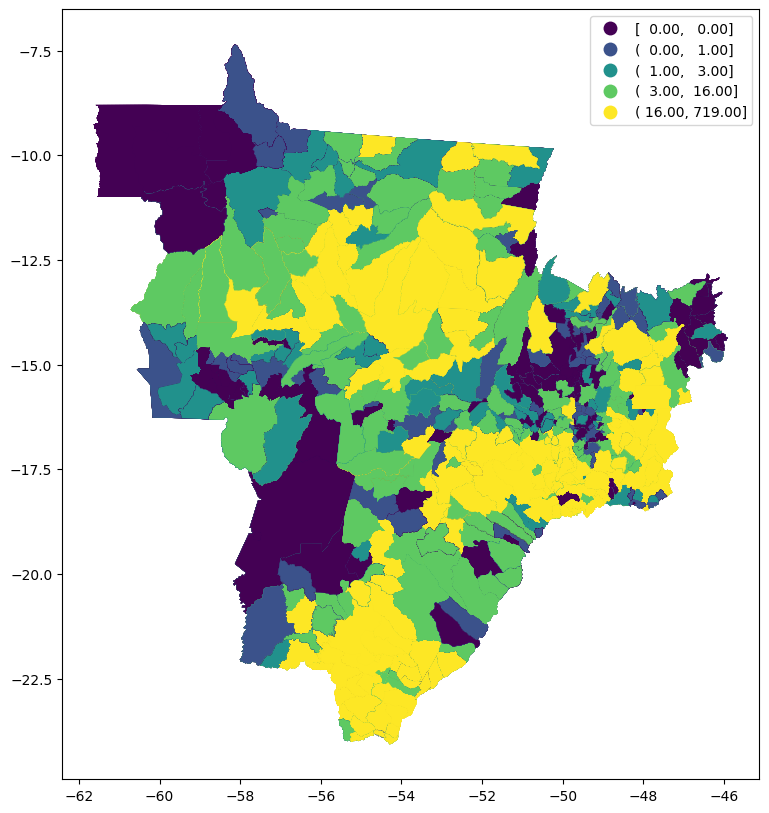

In [35]:
dados_centro_oeste.plot(column='ap_contrat', figsize=(10, 10), scheme='quantiles', legend=True); # , cmap='OrRd' scheme='quantiles',

In [36]:
w = Queen.from_dataframe(dados_centro_oeste[dados_centro_oeste['ano'] == 2019])

In [37]:
mi_results = []
table_I = pd.DataFrame(dados_centro_oeste.ano.unique(), columns=['anos'])
for variavel in variaveis:
    mi_results = [Moran(dados_centro_oeste[dados_centro_oeste['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.I, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I = pd.concat([table_I.reset_index(drop=True), table_p], axis=1)
table_I

,anos,ap_contrat,t_segurado,soma_premio,t_subvencao,inde_pagas,tx_media,ap_indeniz
0,2006,0.241,-0.002,0.046,0.174,-0.002,0.035,-0.003
1,2007,0.221,0.026,0.046,0.092,-0.000,0.095,0.015
2,2008,0.311,0.109,0.179,0.267,0.441,0.157,0.459
3,2009,0.424,0.324,0.370,0.368,0.347,0.530,0.461
4,2010,0.396,0.266,0.363,0.375,0.122,0.300,0.174
5,2011,0.502,0.356,0.442,0.432,0.505,0.580,0.604
6,2012,0.542,0.357,0.475,0.477,0.294,0.458,0.317
7,2013,0.459,0.321,0.422,0.429,0.325,0.426,0.348
8,2014,0.431,0.306,0.402,0.391,0.307,0.434,0.339
9,2015,0.569,0.344,0.459,0.447,0.052,0.494,0.172


In [38]:
mi_results = []
table_I_p = pd.DataFrame(dados_centro_oeste.ano.unique(), columns=['anos'])
for variavel in variaveis:
    mi_results = [Moran(dados_centro_oeste[dados_centro_oeste['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.p_sim, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I_p = pd.concat([table_I_p.reset_index(drop=True), table_p], axis=1)
table_I_p

,anos,ap_contrat,t_segurado,soma_premio,t_subvencao,inde_pagas,tx_media,ap_indeniz
0,2006,0.001,0.483,0.033,0.001,0.447,0.012,0.098
1,2007,0.001,0.040,0.022,0.010,0.091,0.007,0.042
2,2008,0.001,0.002,0.001,0.001,0.001,0.002,0.001
3,2009,0.001,0.001,0.001,0.001,0.001,0.001,0.001
4,2010,0.001,0.001,0.001,0.001,0.004,0.001,0.001
5,2011,0.001,0.001,0.001,0.001,0.001,0.001,0.001
6,2012,0.001,0.001,0.001,0.001,0.001,0.001,0.001
7,2013,0.001,0.001,0.001,0.001,0.001,0.001,0.001
8,2014,0.001,0.001,0.001,0.001,0.001,0.001,0.001
9,2015,0.001,0.001,0.001,0.001,0.058,0.001,0.001


In [39]:
w = Queen.from_dataframe(dados_centro_oeste[dados_centro_oeste['ano'] == 2019])
np.random.seed(123456)

y = dados_centro_oeste[dados_centro_oeste['ano'] == 2019]
mi_results = [Moran(y[variable], w) for variable in variaveis]
table = pd.DataFrame([(variable, res.I, res.p_sim) \
                      for variable,res in zip(variaveis, mi_results)], columns=['Variável', "I", 'valor-p']).set_index('Variável')
table

,I,valor-p
Variável,,
ap_contrat,0.459196,0.001
t_segurado,0.392719,0.001
soma_premio,0.464131,0.001
t_subvencao,0.466197,0.001
inde_pagas,0.219409,0.001
tx_media,0.718401,0.001
ap_indeniz,0.526963,0.001


In [40]:
dados_br.nome_regiao.unique()

array(['Norte', 'Nordeste', 'Sudeste', 'Sul', 'Centro-Oeste'],
      dtype=object)

## Sudeste

In [41]:
dados_sudeste = dados_br.query('nome_regiao == "Sudeste"')

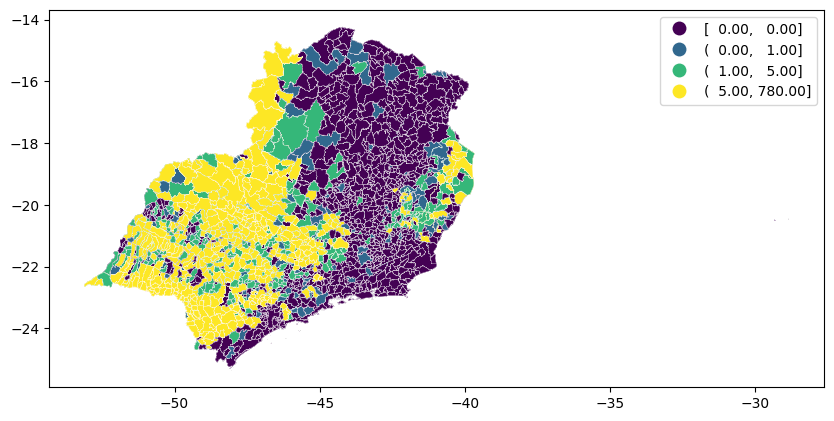

In [42]:
dados_sudeste.plot(column='ap_contrat', figsize=(10, 10), scheme='quantiles', legend=True,  edgecolor='w', linewidths=0.2); # , cmap='OrRd' scheme='quantiles',

In [43]:
w = Queen.from_dataframe(dados_sudeste[dados_sudeste['ano'] == 2019])

In [44]:
mi_results = []
table_I = pd.DataFrame(dados_sudeste.ano.unique(), columns=['anos'])
for variavel in variaveis:
    mi_results = [Moran(dados_sudeste[dados_sudeste['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.I, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I = pd.concat([table_I.reset_index(drop=True), table_p], axis=1)
table_I

,anos,ap_contrat,t_segurado,soma_premio,t_subvencao,inde_pagas,tx_media,ap_indeniz
0,2006,0.429,0.385,0.339,0.330,0.154,0.278,0.132
1,2007,0.477,0.374,0.344,0.360,0.277,0.007,0.333
2,2008,0.474,0.448,0.440,0.454,0.304,0.511,0.330
3,2009,0.446,0.433,0.434,0.431,0.302,0.565,0.309
4,2010,0.438,0.340,0.403,0.404,0.234,0.462,0.314
5,2011,0.440,0.454,0.428,0.422,0.305,0.606,0.404
6,2012,0.508,0.462,0.501,0.503,0.126,0.635,0.161
7,2013,0.506,0.400,0.507,0.498,0.363,0.648,0.424
8,2014,0.487,0.392,0.509,0.502,0.332,0.657,0.326
9,2015,0.476,0.470,0.482,0.478,0.204,0.648,0.125


In [45]:
mi_results = []
table_I_p = pd.DataFrame(dados_sudeste.ano.unique(), columns=['anos'])
for variavel in variaveis:
    mi_results = [Moran(dados_sudeste[dados_sudeste['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.p_sim, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I_p = pd.concat([table_I_p.reset_index(drop=True), table_p], axis=1)
table_I_p

,anos,ap_contrat,t_segurado,soma_premio,t_subvencao,inde_pagas,tx_media,ap_indeniz
0,2006,0.001,0.001,0.001,0.001,0.001,0.001,0.002
1,2007,0.001,0.001,0.001,0.001,0.001,0.001,0.001
2,2008,0.001,0.001,0.001,0.001,0.001,0.001,0.001
3,2009,0.001,0.001,0.001,0.001,0.001,0.001,0.001
4,2010,0.001,0.001,0.001,0.001,0.002,0.001,0.001
5,2011,0.001,0.001,0.001,0.001,0.001,0.001,0.001
6,2012,0.001,0.001,0.001,0.001,0.001,0.001,0.001
7,2013,0.001,0.001,0.001,0.001,0.001,0.001,0.001
8,2014,0.001,0.001,0.001,0.001,0.001,0.001,0.001
9,2015,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [46]:
w = Queen.from_dataframe(dados_sudeste[dados_sudeste['ano'] == 2019])
np.random.seed(123456)

y = dados_sudeste[dados_sudeste['ano'] == 2019]
mi_results = [Moran(y[variable], w) for variable in variaveis]
table = pd.DataFrame([(variable, res.I, res.p_sim) \
                      for variable,res in zip(variaveis, mi_results)], columns=['Variável', "I", 'valor-p']).set_index('Variável')
table

,I,valor-p
Variável,,
ap_contrat,0.497481,0.001
t_segurado,0.507855,0.001
soma_premio,0.518991,0.001
t_subvencao,0.517631,0.001
inde_pagas,0.414142,0.001
tx_media,0.695213,0.001
ap_indeniz,0.336916,0.001


In [47]:
dados_br.nome_regiao.unique()

array(['Norte', 'Nordeste', 'Sudeste', 'Sul', 'Centro-Oeste'],
      dtype=object)

## Sul

In [48]:
dados_sul = dados_br.query('nome_regiao == "Sul"')

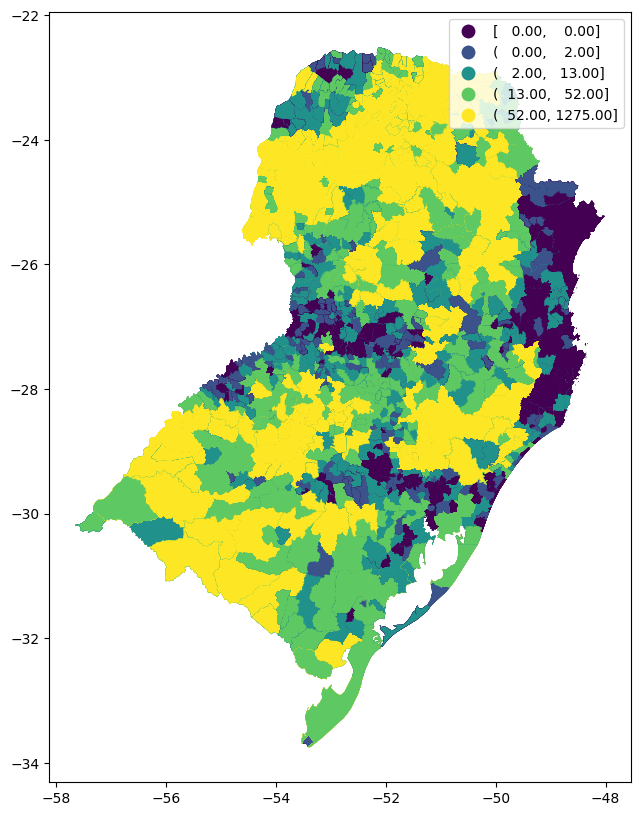

In [49]:
dados_sul.plot(column='ap_contrat', figsize=(10, 10), scheme='quantiles', legend=True); # , cmap='OrRd' scheme='quantiles',

In [50]:
w = Queen.from_dataframe(dados_sul[dados_sul['ano'] == 2019])

In [51]:
mi_results = []
table_I = pd.DataFrame(dados_sul.ano.unique(), columns=['anos'])
for variavel in variaveis:
    mi_results = [Moran(dados_sul[dados_sul['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.I, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I = pd.concat([table_I.reset_index(drop=True), table_p], axis=1)
table_I

,anos,ap_contrat,t_segurado,soma_premio,t_subvencao,inde_pagas,tx_media,ap_indeniz
0,2006,0.558,0.314,0.179,0.208,0.031,0.524,0.177
1,2007,0.476,0.310,0.204,0.209,0.079,0.534,0.208
2,2008,0.403,0.364,0.243,0.251,0.382,0.594,0.427
3,2009,0.439,0.351,0.265,0.264,0.181,0.675,0.291
4,2010,0.416,0.347,0.238,0.234,0.171,0.461,0.219
5,2011,0.447,0.316,0.233,0.230,0.290,0.648,0.373
6,2012,0.470,0.385,0.270,0.271,0.213,0.648,0.398
7,2013,0.500,0.420,0.331,0.338,0.386,0.647,0.477
8,2014,0.517,0.415,0.318,0.326,0.214,0.694,0.424
9,2015,0.536,0.382,0.320,0.327,0.460,0.693,0.501


In [52]:
mi_results = []
table_I_p = pd.DataFrame(dados_sul.ano.unique(), columns=['anos'])
for variavel in variaveis:
    mi_results = [Moran(dados_sul[dados_sul['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.p_sim, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I_p = pd.concat([table_I_p.reset_index(drop=True), table_p], axis=1)
table_I_p

,anos,ap_contrat,t_segurado,soma_premio,t_subvencao,inde_pagas,tx_media,ap_indeniz
0,2006,0.001,0.001,0.001,0.002,0.007,0.001,0.002
1,2007,0.001,0.001,0.002,0.001,0.004,0.001,0.001
2,2008,0.001,0.001,0.001,0.001,0.001,0.001,0.001
3,2009,0.001,0.001,0.001,0.001,0.001,0.001,0.001
4,2010,0.001,0.001,0.001,0.001,0.001,0.001,0.001
5,2011,0.001,0.001,0.001,0.001,0.001,0.001,0.001
6,2012,0.001,0.001,0.001,0.001,0.001,0.001,0.001
7,2013,0.001,0.001,0.001,0.001,0.001,0.001,0.001
8,2014,0.001,0.001,0.001,0.001,0.001,0.001,0.001
9,2015,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [53]:
w = Queen.from_dataframe(dados_sul[dados_sul['ano'] == 2019])
np.random.seed(123456)

y = dados_sul[dados_sul['ano'] == 2019]
mi_results = [Moran(y[variable], w) for variable in variaveis]
table = pd.DataFrame([(variable, res.I, res.p_sim) \
                      for variable,res in zip(variaveis, mi_results)], columns=['Variável', "I", 'valor-p']).set_index('Variável')
table

,I,valor-p
Variável,,
ap_contrat,0.610626,0.001
t_segurado,0.488266,0.001
soma_premio,0.429081,0.001
t_subvencao,0.437533,0.001
inde_pagas,0.362049,0.001
tx_media,0.730261,0.001
ap_indeniz,0.447395,0.001


# Gráficos descritivos

In [54]:
mpl.rcdefaults()

In [55]:
df_norte_soma_anos = dados_norte.groupby('ano', as_index=False).sum()
df_nordeste_soma_anos = dados_nordeste.groupby('ano', as_index=False).sum()
df_coeste_soma_anos = dados_centro_oeste.groupby('ano', as_index=False).sum()
df_sudeste_soma_anos = dados_sudeste.groupby('ano', as_index=False).sum()
df_sul_soma_anos = dados_sul.groupby('ano', as_index=False).sum()

### Apólices contratadas

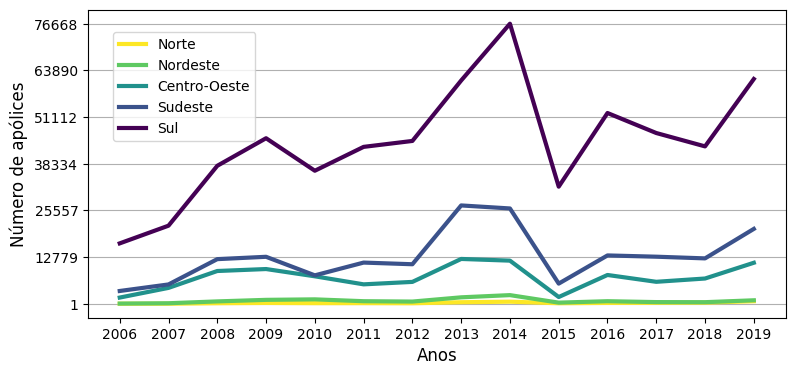

In [56]:
f, ax = plt.subplots(figsize=(9,4)) # 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_norte_soma_anos.ap_contrat, color='#fde725', linewidth=3, label= "Norte") # marker='o', markersize=7, 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_nordeste_soma_anos.ap_contrat, color='#5ec962', linewidth=3, label= "Nordeste") # marker='o', markersize=7, 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_coeste_soma_anos.ap_contrat, color='#21918c',  linewidth=3, label= "Centro-Oeste") # marker='o', markersize=7, 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sudeste_soma_anos.ap_contrat, color='#3b528b', linewidth=3, label= "Sudeste") # marker='o', markersize=7, 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sul_soma_anos.ap_contrat, color='#440154', linewidth=3, label= "Sul") # marker='o', markersize=7, 

yvals = np.linspace((df_norte_soma_anos.ap_contrat).min(), (df_sul_soma_anos.ap_contrat).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)

ax.set_xticks(np.arange(len(anos)))
ax.set_xticklabels(anos, fontsize = 10)
ax.set_ylabel('Número de apólices', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12 )
ax.yaxis.grid()
plt.legend(bbox_to_anchor=(0.25, 0.95))


In [72]:
def anual_g(v_i, v_f, a_i, a_f):
    return round((v_f/v_i) ** (1/(a_f - a_i) - 1 ) * 100,2)

In [91]:
def crescimento(df):
    return(df[13] / df[0])


A taxa de crescimento do número de apólices contratadas na região sul foi de $3,72$ vezes o valor inicial entre os anos $2006$ e $2019$. Por sua vez, durante o período analisado a região Sudeste teve um crescimento do número apólices de $5,87$ vezes e a

A taxa de crescimento médio do número de apólices contratadas na região sul foi de $26,86\%$ entre os anos $2006$ e $2019$. Por sua vez, durante o período analizado a região Sudeste teve um crescimento anual médio do número apólices de $17,03\%$ e a região Centro-Oeste apresentou um crescimento anual de $15\%$. As regiões Norte e Nordeste apresentaram um rescimento anual igual à $0,14\%$ e $4,04\%$ respectivamente. 

Na figura \ref{} é possível observar a evolução do número de apólices contratadas nas regiões brasileiras. Na Figura \ref{} observa-se que a região Sul se destaca das demais com relação ao número de apólices contratadas. O menor número de apólices contratadas na região Sul foi de $16.525$ apólices no ano de $2006$. O valor médio de apólices contratadas durante o período foi $44.166$ apólice. No ano de $2014$ foi registrado o maior número de apólices contratadas ($76.668$ apólices). 

A segunda região com maior número de apólices contratadas é a região Sudeste. Em média, na região Sudeste, foram contratadas $12.942$ apólices por ano, o maior valor registrado foi $26.913$ apólices contratadas em $2013$. A região Centro-Oeste é a terceira região com mais apólices contratadas, em média foram contratadas $7.225$  por ano e, em $2013$ foi registrado o maior número de apólices ($12.260$). Por fim, as regiões Norte e Nordeste, apresentaram respectivamente, em média, $240$ e $804$ apólices contratadas por ano.

### Valores do prêmio e de subvenção ao prêmio de seguro rural

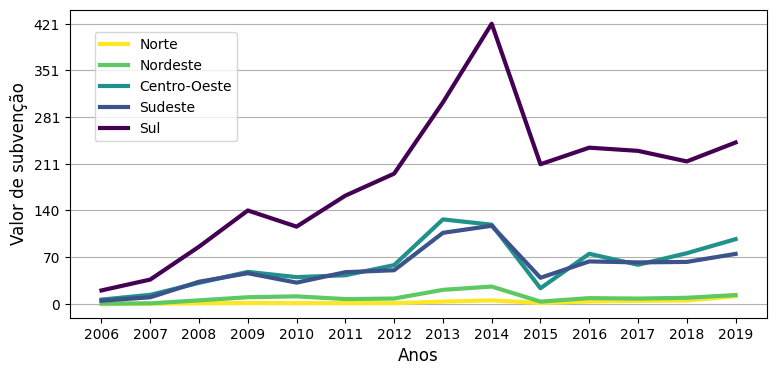

In [58]:
f, ax = plt.subplots(figsize=(9,4)) # 

plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_norte_soma_anos.t_subvencao/1000000, color='#fde725', linewidth=3, label= "Norte") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_nordeste_soma_anos.t_subvencao/1000000, color='#5ec962', linewidth=3, label= "Nordeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_coeste_soma_anos.t_subvencao/1000000, color='#21918c',  linewidth=3, label= "Centro-Oeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sudeste_soma_anos.t_subvencao/1000000, color='#3b528b', linewidth=3, label= "Sudeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sul_soma_anos.t_subvencao/1000000, color='#440154', linewidth=3, label= "Sul") 

ax.set_xticks(np.arange(len(df_norte_soma_anos.ano)))
ax.set_xticklabels(df_norte_soma_anos.ano, fontsize = 10)

yvals = np.linspace((df_norte_soma_anos['t_subvencao']/1000000).min(), (df_sul_soma_anos['t_subvencao']/1000000).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)

ax.set_ylabel('Valor de subvenção', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid()
plt.legend( bbox_to_anchor=(0.25, 0.95),);

In [59]:
#plt.bar(pos, norte, label='Norte',color='#fde725')
#plt.bar(pos, nordeste, bottom = norte, label='Nordeste',color='#5ec962')
#plt.bar(pos, centro_oeste, bottom = norte + nordeste, label='Centro-Oeste', color='#21918c')
#plt.bar(pos, sudeste, bottom = norte + nordeste + centro_oeste, label='Sudeste', color='#3b528b')
#plt.bar(pos, sul, bottom = norte + nordeste + centro_oeste + sudeste, label='Sul', color='#440154')


f, ax = plt.subplots(figsize=(13,6)) # 

pos = np.arange(len(anos))

plt.bar(pos, sul, label='Norte',color='#440154')
plt.bar(pos, sudeste, bottom = sul, label='Sudeste',color='#3b528b')
plt.bar(pos, centro_oeste, bottom = sul + sudeste, label='Centro-Oeste', color='#21918c')
plt.bar(pos, nordeste, bottom = sul + sudeste + centro_oeste, label='Nordeste', color='#5ec962')
plt.bar(pos, norte, bottom = sul + sudeste + centro_oeste + nordeste, label='Norte', color='#fde725')

ax.set_xticks(pos)
ax.set_xticklabels(anos, fontsize = 12)
ax.set_ylabel('Percentual de subvenção', fontsize = 15)
ax.set_xlabel('Anos', fontsize = 15)

fmt = '%.0f%%' 
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

plt.legend(bbox_to_anchor=(0.97, -0.13), ncol=5, fontsize=15)
plt.show() 

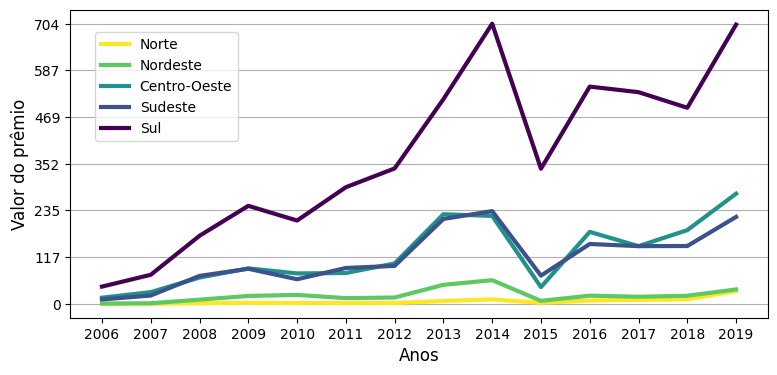

In [60]:
f, ax = plt.subplots(figsize=(9,4)) # 

plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_norte_soma_anos.soma_premio/1000000, color='#fde725', linewidth=3, label= "Norte") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_nordeste_soma_anos.soma_premio/1000000, color='#5ec962', linewidth=3, label= "Nordeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_coeste_soma_anos.soma_premio/1000000, color='#21918c',  linewidth=3, label= "Centro-Oeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sudeste_soma_anos.soma_premio/1000000, color='#3b528b', linewidth=3, label= "Sudeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sul_soma_anos.soma_premio/1000000, color='#440154', linewidth=3, label= "Sul") 


ax.set_xticks(np.arange(len(df_norte_soma_anos.ano)))
ax.set_xticklabels(df_norte_soma_anos.ano, fontsize = 10)

yvals = np.linspace((df_norte_soma_anos['soma_premio']/1000000).min(), (df_sul_soma_anos['soma_premio']/1000000).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)


ax.set_ylabel('Valor do prêmio', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid()
plt.legend( bbox_to_anchor=(0.25, 0.95),);

### Total segurado

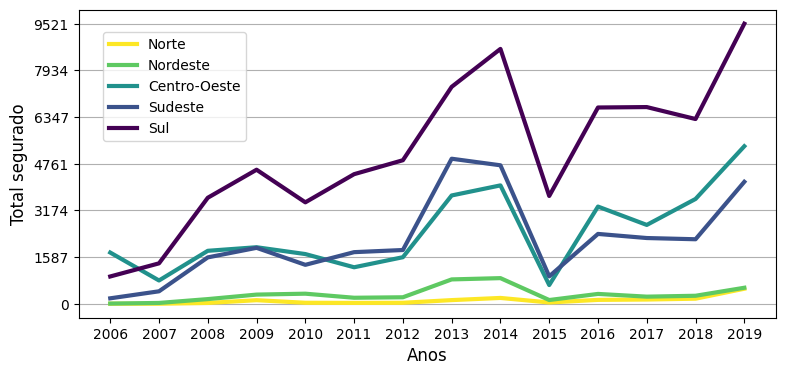

In [140]:
f, ax = plt.subplots(figsize=(9,4)) #f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_norte_soma_anos.t_segurado/1000000, color='#fde725', linewidth=3, label= "Norte") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_nordeste_soma_anos.t_segurado/1000000, color='#5ec962', linewidth=3, label= "Nordeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_coeste_soma_anos.t_segurado/1000000, color='#21918c',  linewidth=3, label= "Centro-Oeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sudeste_soma_anos.t_segurado/1000000, color='#3b528b', linewidth=3, label= "Sudeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sul_soma_anos.t_segurado/1000000, color='#440154', linewidth=3, label= "Sul") 

ax.set_xticks(np.arange(len(df_norte_soma_anos.ano)))
ax.set_xticklabels(df_norte_soma_anos.ano, fontsize = 10)

yvals = np.linspace((df_norte_soma_anos['t_segurado']/1000000).min(), (df_sul_soma_anos['t_segurado']/1000000).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)


ax.set_ylabel('Total segurado', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid()
plt.legend( bbox_to_anchor=(0.25, 0.95),);

### Taxa média de contratação de seguro rural 

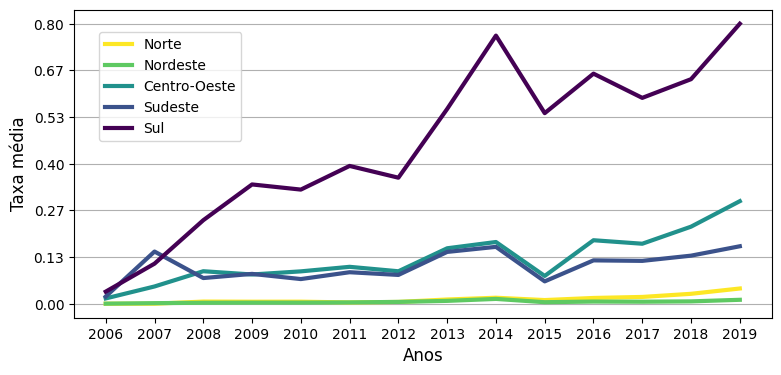

In [63]:
f, ax = plt.subplots(figsize=(9,4)) #f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(df_norte_soma_anos.ano)), dados_norte.groupby('ano', as_index=False).mean().tx_media, color='#fde725', linewidth=3, label= "Norte") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), dados_nordeste.groupby('ano', as_index=False).mean().tx_media, color='#5ec962', linewidth=3, label= "Nordeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), dados_centro_oeste.groupby('ano', as_index=False).mean().tx_media, color='#21918c',  linewidth=3, label= "Centro-Oeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), dados_sudeste.groupby('ano', as_index=False).mean().tx_media, color='#3b528b', linewidth=3, label= "Sudeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), dados_sul.groupby('ano', as_index=False).mean().tx_media, color='#440154', linewidth=3, label= "Sul") 

ax.set_xticks(np.arange(len(df_norte_soma_anos.ano)))
ax.set_xticklabels(df_norte_soma_anos.ano, fontsize = 10)

yvals = np.linspace(dados_norte.groupby('ano', as_index=False).mean().tx_media.min(), dados_sul.groupby('ano', as_index=False).mean().tx_media.max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.2f}".format(y) for y in yvals], fontsize=10)

ax.set_ylabel('Taxa média', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid()
plt.legend( bbox_to_anchor=(0.25, 0.95),);

## Indenizações

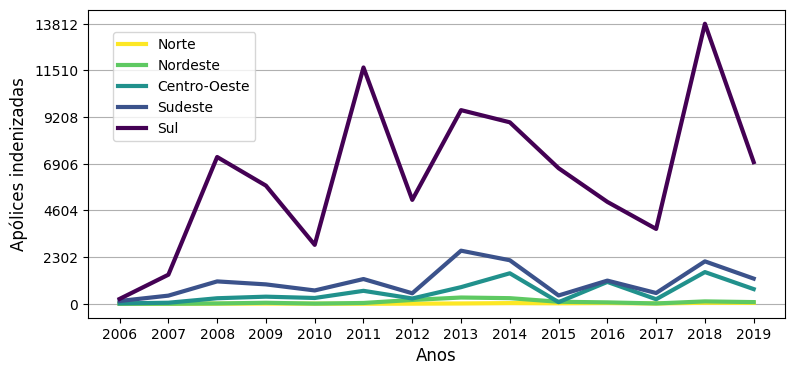

In [64]:
f, ax = plt.subplots(figsize=(9,4)) #f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_norte_soma_anos.ap_indeniz, color='#fde725', linewidth=3, label= "Norte") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_nordeste_soma_anos.ap_indeniz, color='#5ec962', linewidth=3, label= "Nordeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_coeste_soma_anos.ap_indeniz, color='#21918c',  linewidth=3, label= "Centro-Oeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sudeste_soma_anos.ap_indeniz, color='#3b528b', linewidth=3, label= "Sudeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sul_soma_anos.ap_indeniz, color='#440154', linewidth=3, label= "Sul") 

ax.set_xticks(np.arange(len(df_norte_soma_anos.ano)))
ax.set_xticklabels(df_norte_soma_anos.ano, fontsize = 10)

yvals = np.linspace((df_norte_soma_anos['ap_indeniz']).min(), (df_sul_soma_anos['ap_indeniz']).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)

ax.set_ylabel('Apólices indenizadas', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid()
plt.legend( bbox_to_anchor=(0.25, 0.95),);

In [151]:
crescimento(df_sul_soma_anos.ap_indeniz)

29.468354430379748

 É possível observar na Figura \ref{ap_contrat_regioes} que a região Sul se destaca quando se analisa o número de apólices contratadas. Os valores variam de $237$ em $2006$ e $13812$ apólices contratadas em $2019$. Em média, a região Sul teve cerca de $6364$ apólices contratadas durante o período. Além disso, durante os anos analisados, houve um crescimento de $58,28\%$ no número de apólices de seguro rural contratadas. A região Sudeste é a segunda região com maior número de apólices contratadas. O menor número de apólices contratadas na região Sudeste foi de $135$ e ocorreu em $2006$, o maior valor foi registrado em $2013$ e foi equivalente à $2616$. Ao longo dos anos analisados a diferença entre o número de apólices entre a região Sul e Sudeste foi em média igual à $5283$ apólices. A região Centro-Oeste foi responsável por, em média, $559,64$ apólices contratadas. O maior número de apólices contratadas na região Centro-Oeste foi registrado em $2018$ e foi igual a $1561$ apólices. As regiões Norte e Nordeste tiveram em média $15,57$ e $88,64$, respectivamente. 

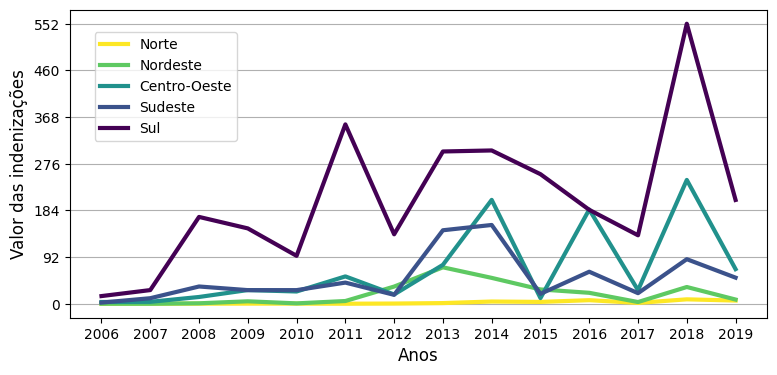

In [66]:
f, ax = plt.subplots(figsize=(9,4)) #f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_norte_soma_anos.inde_pagas/1000000, color='#fde725', linewidth=3, label= "Norte") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_nordeste_soma_anos.inde_pagas/1000000, color='#5ec962', linewidth=3, label= "Nordeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_coeste_soma_anos.inde_pagas/1000000, color='#21918c',  linewidth=3, label= "Centro-Oeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sudeste_soma_anos.inde_pagas/1000000, color='#3b528b', linewidth=3, label= "Sudeste") 
plt.plot(np.arange(len(df_norte_soma_anos.ano)), df_sul_soma_anos.inde_pagas/1000000, color='#440154', linewidth=3, label= "Sul") 

ax.set_xticks(np.arange(len(df_norte_soma_anos.ano)))
ax.set_xticklabels(df_norte_soma_anos.ano, fontsize = 10)

yvals = np.linspace((df_norte_soma_anos['inde_pagas']/1000000).min(), (df_sul_soma_anos['inde_pagas']/1000000).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)


ax.set_ylabel('Valor das indenizações', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid()
plt.legend( bbox_to_anchor=(0.25, 0.95),);

In [67]:
(df_sul_soma_anos.inde_pagas/1000000)

0      15.062350
1      26.870112
2     171.046530
3     148.426454
4      94.364821
5     353.367630
6     136.804244
7     299.999195
8     302.019351
9     255.269631
10    185.008697
11    134.821638
12    551.741064
13    204.476217
Name: inde_pagas, dtype: float64

Com relação ao valor das indenizações de seguro rural pagas, é possível observar na Figura \ref{inde_pagas_regioes}, que a região Sul é a que possui os maiores valores pagos como indenização. Em média, foram pagos R$\$205,66$ milhões como indenização. O maior valor foi equivalente à R$\%551,744 milhões e foi registrado em $2018$ e o menor valor foi registrado no primeiro ano analizado e foi equivalente à R$\%15.06$ milhões. 

## Tabela médias regiões

In [68]:
regioes = ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']
table_means = pd.DataFrame(index=[variaveis], columns=[regioes])

In [69]:
for i, variavel in enumerate(variaveis):
    for j, regiao in enumerate(regioes):
        if variavel in ['t_segurado', 'soma_premio', 't_subvencao', 'inde_pagas']:
                table_means.iloc[i,j] = round((dados_br[dados_br['nome_regiao']==regiao].groupby('ano', as_index=False).sum()[variavel]/1000000).mean(),2)
        elif variavel in ['tx_media']:
            table_means.iloc[i,j] = round(dados_br[dados_br['nome_regiao']==regiao].groupby('ano', as_index=False).mean()['tx_media'].mean(),2)
        else:
            table_means.iloc[i,j] = round(dados_br[dados_br['nome_regiao']==regiao].groupby('ano', as_index=False).sum()[variavel].mean(),2)

In [70]:
table_means.to_latex()

'\\begin{tabular}{llllll}\n\\toprule\n           &   Norte & Nordeste & Centro-Oeste &  Sudeste &       Sul \\\\\n\\midrule\nap\\_contrat &  240.14 &   803.57 &      7225.36 &  12941.5 &  44166.14 \\\\\nt\\_segurado &   111.5 &   319.82 &      2428.79 &  2178.54 &   5146.84 \\\\\nsoma\\_premio &    6.37 &    20.76 &       123.43 &   115.02 &    371.72 \\\\\nt\\_subvencao &    2.66 &     9.25 &        58.25 &    53.52 &    186.56 \\\\\ninde\\_pagas &    2.39 &    18.73 &        68.59 &    50.15 &    205.66 \\\\\ntx\\_media &    0.01 &     0.01 &         0.13 &     0.11 &      0.45 \\\\\nap\\_indeniz &   15.57 &    88.64 &       559.64 &  1081.57 &   6364.57 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [71]:
round((dados_br[dados_br['nome_regiao']=='Nordeste'].groupby('ano', as_index=False).sum()[variavel]/1000000),2)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
Name: ap_indeniz, dtype: float64